In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import flayer
import feo_thermodynamics as feot
import earth_model
import layer_setup

In [2]:
# Flayer setup
f_layer_thickness = 200_000 # m
xfe_outer_core = 0.95 # mol frac Fe

# Transport and growth properties
growth_prefactor = 150.0 # (k0) m/s
chemical_diffusivity = 1.0e-9
thermal_conductivity = 100.0
kinematic_viscosity = 1.0e-6

# Nucleation
i0 = 1.0e-10 # (I0) # s^-1m^-3
surf_energy = 1.08e-2 # (gamma) J/m^2
wetting_angle = 180.0 # degrees

# Numerics
number_of_analysis_points = 100
number_of_knots = 5

# Sensible defaults below
hetrogeneous_radius=None
r_icb=1221.5E3
r_cmb=3480.0E3
gruneisen_parameter=1.5
start_time=0.0
max_time=1.0E12
max_rel_error=1.0E-5
max_absolute_error=1.0E-8
verbose=False

k0 = 150.0
dl = 1.0E-9
k = 100.0
mu = 1.0E-6
i0 = 1.0E-10
surf_energy = 1.08E-2
wetting_angle = 180.0
hetrogeneous_radius = None

In [3]:
# Setup the f-layer

# Derived radii
r_flayer_top = r_icb + f_layer_thickness
        
# Discretisation points
nucleation_radii = np.linspace(r_icb, r_flayer_top, number_of_analysis_points)
analysis_radii = np.linspace(r_icb, r_flayer_top, number_of_analysis_points)
knott_radii = np.linspace(r_icb, r_flayer_top, number_of_knots)

# Reuse general layer setup code, but we don't need many of the functions
# so we never need to rerun this (fairly expensive) function
_, adiabatic_temperature_function, _, _, _, pressure_function, gravity_function, _ = layer_setup.setup_flayer_functions(
    r_icb, r_cmb, f_layer_thickness, gruneisen_parameter, 10, xfe_outer_core, xfe_outer_core, knott_radii)

/Users/andreww/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in find_liquidus (vectorized)
  outputs = ufunc(*inputs)


In [26]:
cases_dict = {"dt": [], "dx": [], "N2": [], "L": []}

In [27]:
for delta_t_icb in [-10.0, -20.0, -30.0, -40.0, -50.0]:
    for delta_x_icb in [-0.005, -0.004, -0.003, -0.002, -0.001, 0.0, 0.001, 0.002, 0.003, 0.004, 0.005]:
        temperature_function = layer_setup.fit_quad_func_boundaries(
            r_icb, r_flayer_top, adiabatic_temperature_function(r_icb)+delta_t_icb, 
            adiabatic_temperature_function(r_flayer_top))
        composition_function = layer_setup.fit_quad_func_boundaries(
            r_icb, r_flayer_top, xfe_outer_core+delta_x_icb, xfe_outer_core)
        Nbv, N2 = layer_setup.estimate_brunt_vaisala_frequency(
            r_flayer_top, r_icb, temperature_function, adiabatic_temperature_function,
            composition_function, gravity_function, pressure_function)

        print(f"Dt = {delta_t_icb}, delta_x = {delta_x_icb}, BV freq = {Nbv}")
        if N2 > 0.0:
            solutions, particle_densities, growth_rate, solid_vf, \
            particle_radius_unnormalised, partial_particle_densities, \
            crit_nuc_radii, nucleation_rates, t_points_out, xl_points_out, total_latent_heat, total_o_rate =flayer.evaluate_flayer(
            temperature_function, composition_function, pressure_function, gravity_function, 0.0, 1.0E20,
                    k0, dl, k, mu, i0, surf_energy, wetting_angle, hetrogeneous_radius,
                    nucleation_radii, analysis_radii, r_icb, 
                    r_flayer_top, verbose=False, silent=True)

            print(f"Heat from crystalisation = {total_latent_heat/1.0E12} TW, oxygen = {total_o_rate/1.0E9} Tg/s")
            cases_dict["L"].append(total_latent_heat)
            cases_dict["dt"].append(delta_t_icb)
            cases_dict["dx"].append(delta_x_icb)
            cases_dict["N2"].append(N2)


Dt = -10.0, delta_x = -0.005, BV freq = 0.00017273872329067724j
Dt = -10.0, delta_x = -0.004, BV freq = 0.00015326421196587943j
Dt = -10.0, delta_x = -0.003, BV freq = 0.00013090743610372836j
Dt = -10.0, delta_x = -0.002, BV freq = 0.00010382280740865612j
Dt = -10.0, delta_x = -0.001, BV freq = 6.646178249381776e-05j
Dt = -10.0, delta_x = 0.0, BV freq = 4.415052968993785e-05
Heat from crystalisation = 2.349794531455918 TW, oxygen = 4.424670908005406e-05 Tg/s
Dt = -10.0, delta_x = 0.001, BV freq = 9.121482207777988e-05
Radius 2532.7229970531052 m capped to 2 m in falling
Radius 2532.7229970531052 m capped to 2 m in falling
Heat from crystalisation = 5.871529701151761 TW, oxygen = 0.00010841875482793889 Tg/s
Dt = -10.0, delta_x = 0.001, BV freq = 9.121482207777988e-05
Radius 2532.7229970531052 m capped to 2 m in falling
Radius 2532.7229970531052 m capped to 2 m in falling
Heat from crystalisation = 5.871529701151761 TW, oxygen = 0.00010841875482793889 Tg/s
Dt = -10.0, delta_x = 0.002, BV

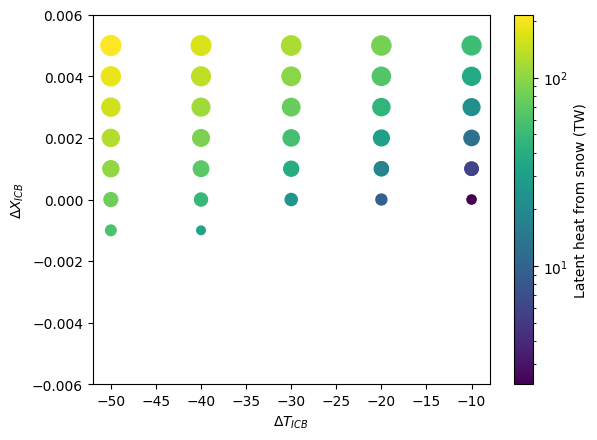

In [49]:
import matplotlib.colors as colors
fig, ax = plt.subplots()
c = ax.scatter(cases_dict["dt"], cases_dict["dx"], c=np.array(cases_dict["L"])/1.0E12,
              norm=colors.LogNorm(), cmap='viridis', s=np.sqrt(np.array(cases_dict["N2"]))*1E6)
ax.set_ylabel("$\Delta X_{ICB}$")
ax.set_xlabel("$\Delta T_{ICB}$")
ax.set_ylim(-0.006, 0.006)
fig.colorbar(c, label='Latent heat from snow (TW)')
plt.show()